In [1]:
from math import sqrt, exp, log, pi
from scipy.stats import norm

#   Function to calculate the values of d1 and d2 as well as the call
#   price.  To extend to puts, one could just add a function that
#   calculates the put price, or combine calls and puts into a single
#   function that takes an argument specifying which type of contract one
#   is dealing with.
def d(sigma, S, K, r, q, t):
    d1 = 1 / (sigma * sqrt(t)) * ( log(S/K) + (r - q + sigma**2/2) * t)
    d2 = d1 - sigma * sqrt(t)
    return d1, d2

def call_price(sigma, S, K, r, q, t, d1, d2):
    C = norm.cdf(d1) * S * exp(-q * t)- norm.cdf(d2) * K * exp(-r * t)
    return C

def impliedVol(S, K, t, r, q, C0):
    #  Tolerances
    tol = 1e-3
    epsilon = 1

    #  Variables to log and manage number of iterations
    count = 0
    max_iter = 1000

    #  We need to provide an initial guess for the root of our function
    vol = 0.50

    while epsilon > tol:
        #  Count how many iterations and make sure while loop doesn't run away
        count += 1
        if count >= max_iter:
            print('Breaking on count')
            break;

        #  Log the value previously calculated to computer percent change
        #  between iterations
        orig_vol = vol

        #  Calculate the value of the call price
        d1, d2 = d(vol, S, K, r, q, t)
        function_value = call_price(vol, S, K, r, q, t, d1, d2) - C0

        #  Calculate vega, the derivative of the price with respect to
        #  volatility
        vega = S * norm.pdf(d1) * sqrt(t)* exp(-q * t)

        #  Update for value of the volatility
        vol = -function_value / vega + vol

        #  Check the percent change between current and last iteration
        epsilon = abs( (vol - orig_vol) / orig_vol )

        return vol

S = 100.0
K = 100
t = 1
r = 0.1
q = 0.0
C0 = 10.45
#  Print out the results
print('Sigma = ', impliedVol(S, K, t, r, q, C0))

Sigma =  0.12619314969556605


Non so quale sono i prezzi veri e quelli ottenuti con la calibrazione. Assumo che heston_calib2 siano i secondi, eventualmente scambia i valori nella formula perché non è simmetrica.

In [2]:
import csv
import numpy as np
from heston import fourier_call_price, fourier_call_price_2
import pandas as pd

stock = pd.read_csv("stock_p.csv", index_col = 0)
price = pd.read_csv("heston_calib2.csv") #prezzi di mercato
calib = pd.read_csv("heston_prices2.csv") #prezzi parametri calibrati

#df= pd.read_csv('stock_p.csv',index_col = 0)
S= stock['2'].tolist()
#print(S)



In [3]:
iv_res = []
# faccio il loop sul file dei parametri
for day in range(len(stock)):
    St = S[day]
    err_iv = 0
    # per ogni riga di ogni file dei prezzi ho 32 opzioni
    # quindi faccio il loop su ogni prezzo di ogni riga
    i = 0
    for T in [0.5, 1, 1.5, 2]:
         for K in np.arange(85, 125, 5):

            # implied volatility per i calibrati
            iv_cal = impliedVol(St, K, T, r, 0, calib.loc[day][i])

            # implied volatility per i prezzi di mercato
            iv_pri = impliedVol(St, K, T, r, 0, price.loc[day][i])

            err_iv += abs(iv_cal - iv_pri)/iv_pri
            i += 1

    iv_res.append(err_iv/32) # dividi per 32 perché fai la media giornaliera dei vari errori

# se vuoi poi puoi salvare il iv_res su csv, ma non so se servirà
#stock[day]['2']


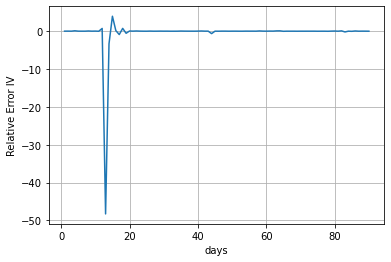

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(1, len(iv_res)+1), iv_res)
plt.xlabel("days")
plt.ylabel("Relative Error IV")
plt.grid(True)
plt.show()